In [2]:
import numpy as np
from epyt import epanet
#from ray.rllib.algorithms.algorithm import Algorithm

from esc.water_usage import MINUTES_PER_DAY, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, relative_occupant_water_demand
from esc.electricity_rates import electricity_rate


In [3]:
#algo = Algorithm.from_checkpoint('../data/models/test01/checkpoint_000851')

In [4]:
d = epanet("../networks/BUILDING.inp")

EPANET version 20200 loaded (EPyT version 1.0.1).
Input File BUILDING.inp loaded successfully.



In [5]:
SIMULATION_DURATION_S = 172800
SIMULATION_TIMESTEP_S = 60
N_SIMULATION_STEPS = SIMULATION_DURATION_S / SIMULATION_TIMESTEP_S

d.setTimeSimulationDuration(SIMULATION_DURATION_S) # 48 hour duration
d.setTimeHydraulicStep(SIMULATION_TIMESTEP_S) # Time step every minute
d.setTimePatternStep(SIMULATION_TIMESTEP_S) # Pattern step every minute

In [6]:
# Add time-dependent pattern for occupant demand to the outflow junction
# Sample the demand for every minute of the day
demand_sample_24h = relative_occupant_water_demand(np.arange(N_SIMULATION_STEPS))
d.addPattern("relative_occupant_demand", demand_sample_24h)
d.setNodeJunctionData(1, 0, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, 'relative_occupant_demand')

In [7]:
d.deleteControls()
tankID = 'T1'
pumpID = 'PUMP'

tankIndex = d.getNodeIndex(tankID)
pumpIndex = d.getLinkIndex(pumpID)
tankElevation = d.getNodeElevations(tankIndex)
setNodeTankInitialLevel(value, *argv)

# Hydraulic analysis STEP-BY-STEP.
d.openHydraulicAnalysis()
d.initializeHydraulicAnalysis(0)

tstep = 1
i = 0
T, P, F, S, E = [], [], [], [], []

# CONTROLS.
MIN_TO_RUN = 120
HEAD_MIN = 2
def naive_model(head_level, mins_was_on):
    
    if (head_level < HEAD_MIN):
        return (1, mins_was_on + 1)
    elif(mins_was_on > 0 and mins_was_on < MIN_TO_RUN):
        return (1, mins_was_on + 1)
    else:
        return (0, 0)

Below = 0.07
Above = 0.08
tankHead = []
pumpStatus = []
mins_was_on = 0
first = True
while tstep > 0:
    H = d.getNodeHydraulicHead()
    current_head = H[tankIndex - 1] - tankElevation
    tankHead.append(current_head)
    
    #print("current head")
    #print(current_head)

    #action = algo.compute_single_action(observation=np.array([electricity_rate(i), relative_occupant_water_demand(i), tankHead[-1]]))
    action, mins_was_on = naive_model(current_head, mins_was_on)
    #print("action, mins was on :" + str(action) + " " + str(mins_was_on))
    pumpStatus.append(action)
    d.setLinkStatus(pumpIndex, action)
    i += 1

    t = d.runHydraulicAnalysis()

    S.append(d.getLinkStatus(pumpIndex))
    F.append(d.getLinkFlows())
    P.append(d.getNodePressure())
    E.append(d.getLinkEnergy(pumpIndex))
    T.append(t)

    tstep = d.nextHydraulicAnalysisStep()

d.closeHydraulicAnalysis()
print("Hydraulic Analysis completed succesfully.")

Hydraulic Analysis completed succesfully.


/Users/nicholas/miniforge3/envs/engineering-smart-cities/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


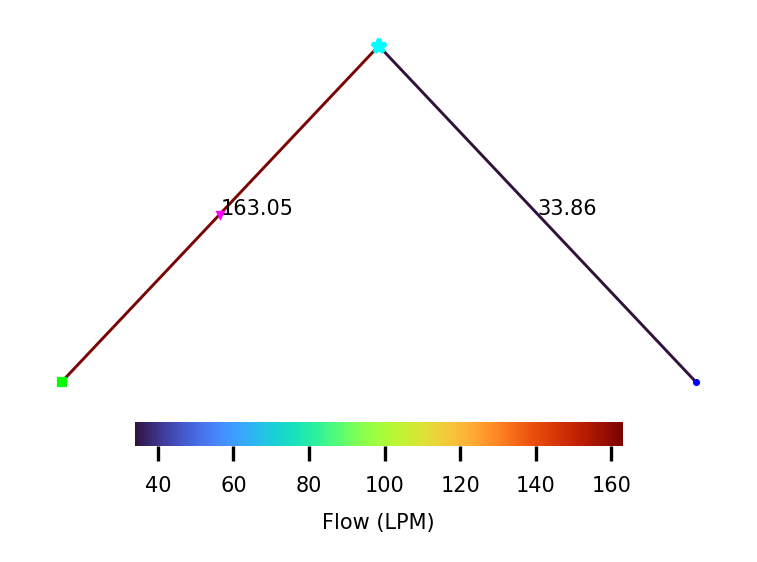

In [8]:
_ = d.plot(flow=F[48], flow_text=True)

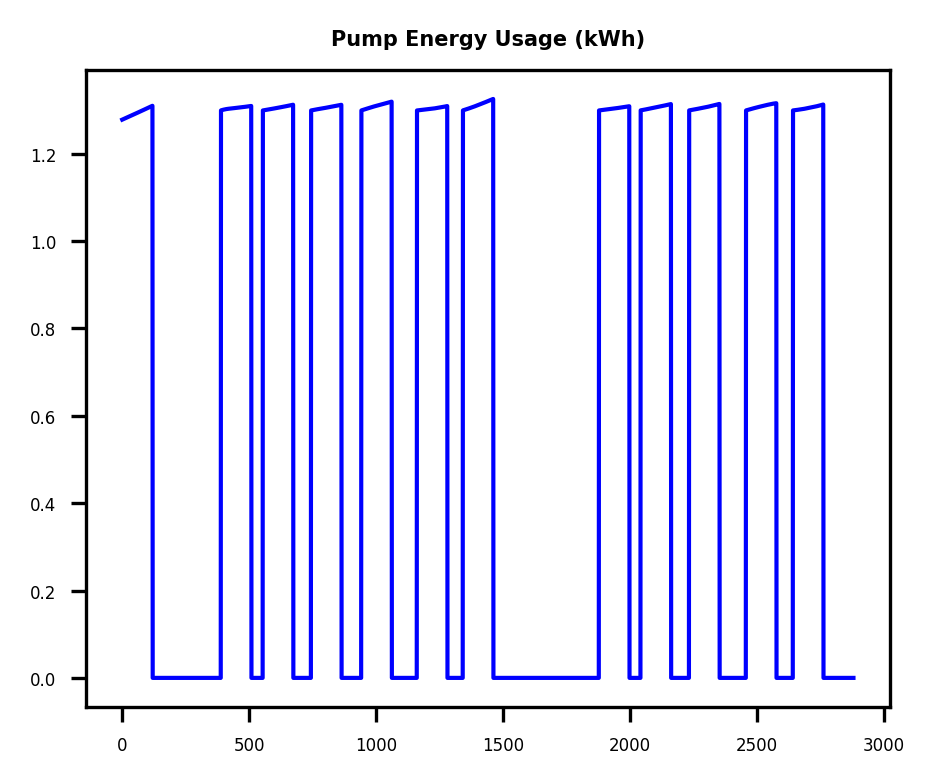

In [9]:
d.plot_ts(Y=E, title="Pump Energy Usage (kWh)", marker=False)

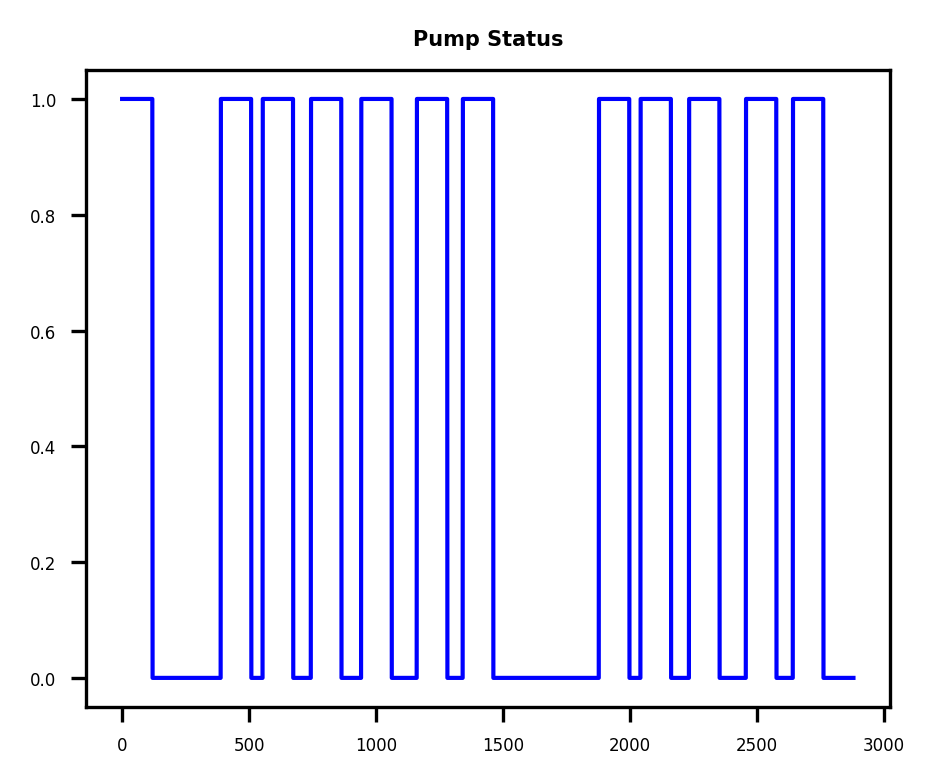

In [10]:
d.plot_ts(Y=pumpStatus, title="Pump Status", marker=False)

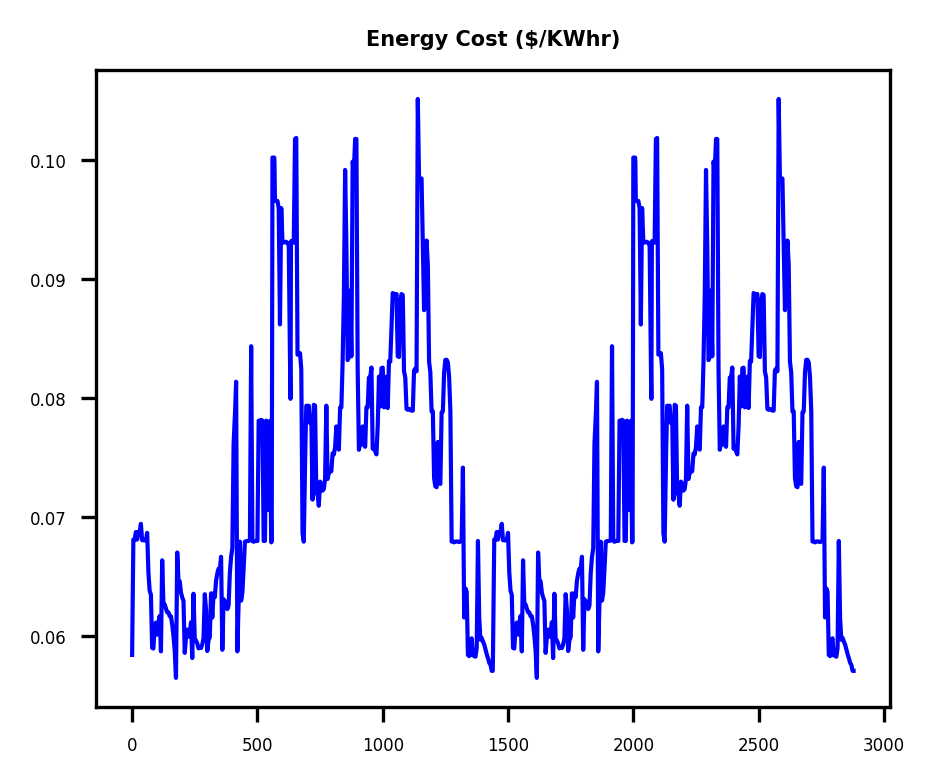

In [11]:
d.plot_ts(Y=electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Energy Cost ($/KWhr)", marker=False)

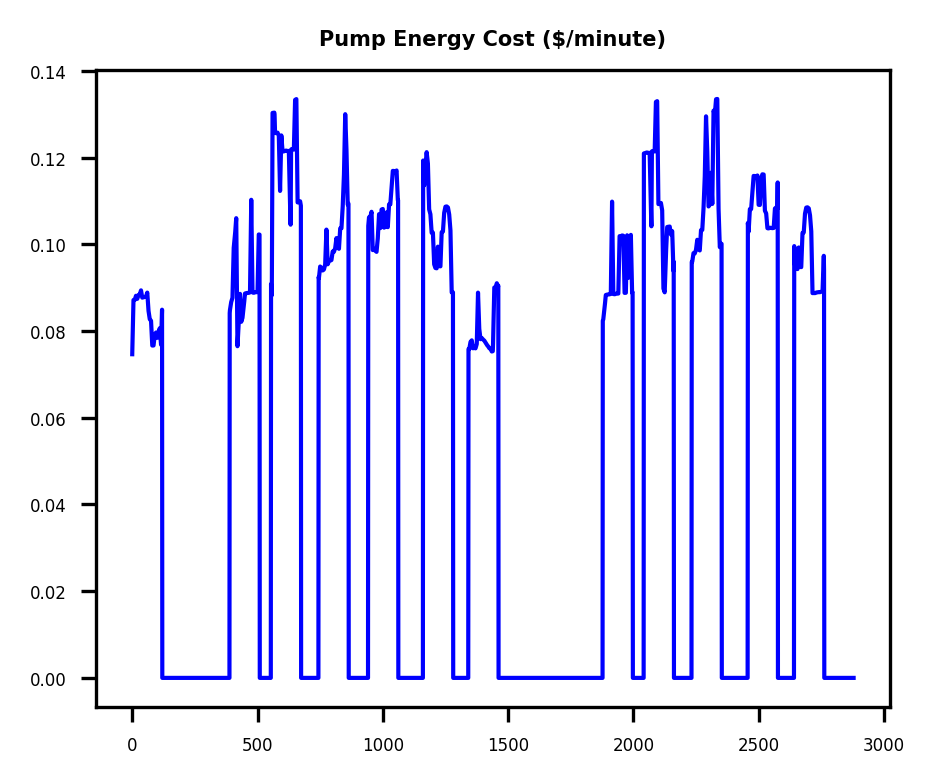

In [12]:
d.plot_ts(Y=np.array(E[:2880]) * electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Pump Energy Cost ($/minute)", marker=False)

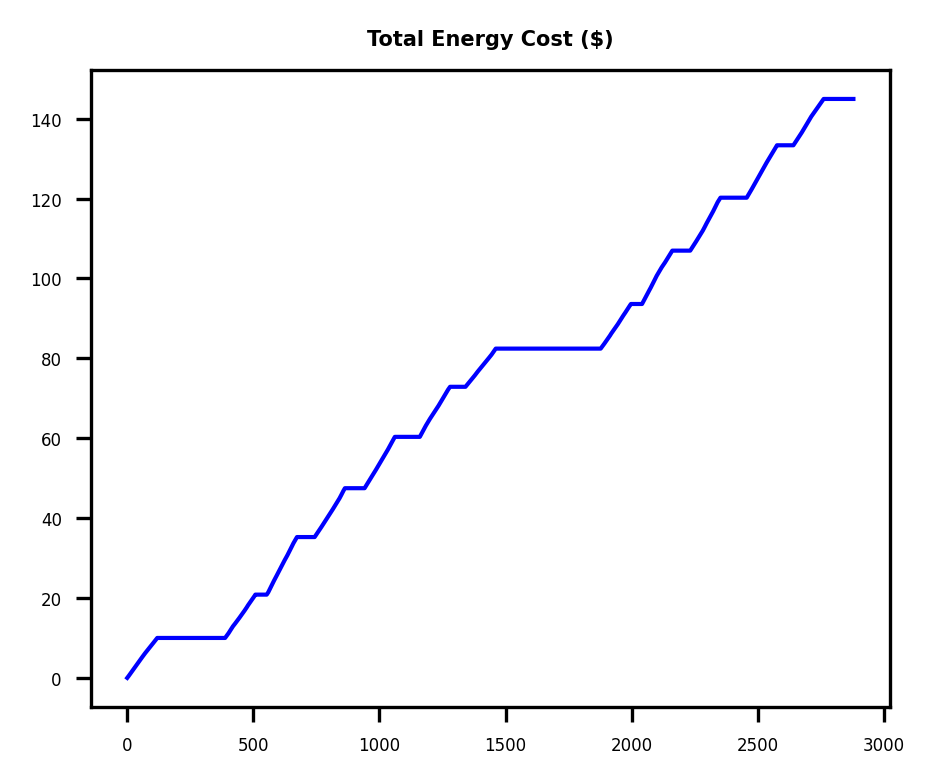

In [13]:
d.plot_ts(Y=np.cumsum(np.array(E[:2880]) * electricity_rate(np.arange(N_SIMULATION_STEPS))), title="Total Energy Cost ($)", marker=False)

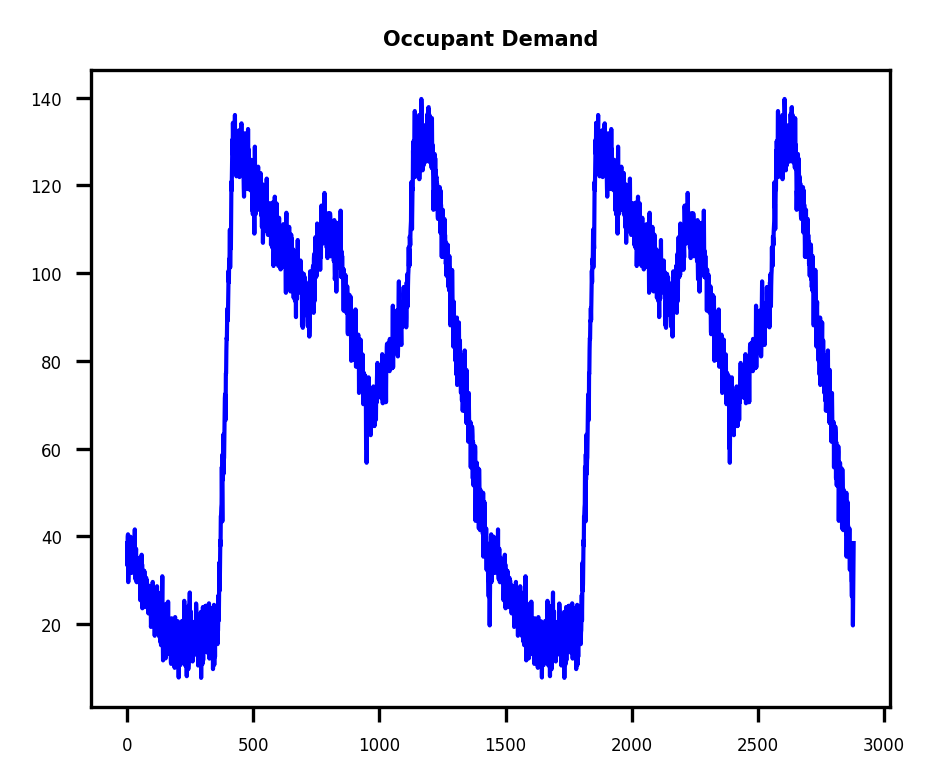

In [14]:
d.plot_ts(Y=np.array(F)[:, 0], title="Occupant Demand", marker=False)

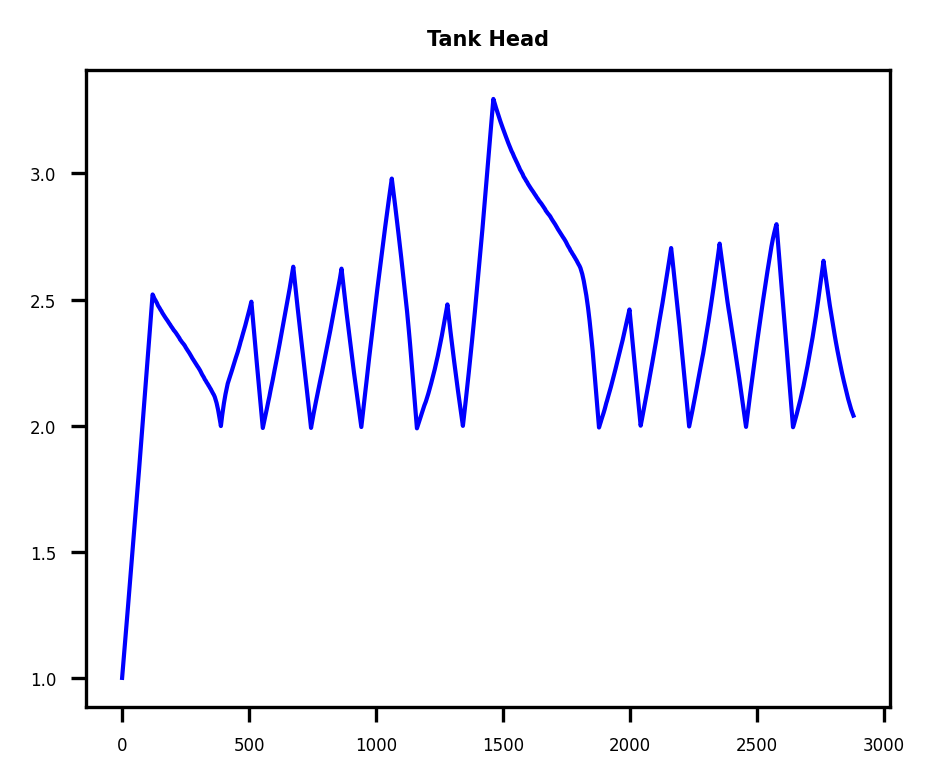

In [15]:
d.plot_ts(Y=tankHead, title='Tank Head', marker=False)